## Enunciado

>Considere el proyecto cuya información se adjunta.
> 1. Dibuje el diagrama Pert y determine el camino crítico.
> 2. Reduzca la duración del proyecto dos unidades de tiempo con el menor incremento de coste posible.

In [1]:
!apt install libgraphviz-dev              > /dev/null
%pip install pygraphviz "pandas[excel]"   > /dev/null
%pip install numpyarray_to_latex          > /dev/null

repo_url = 'https://github.com/mcasl/pmULE'
repo_name = "pmULE"

import os, sys

if not os.path.exists(repo_name):
    print(f"Cloning repository '{repo_name}'...")
    !git clone {repo_url}
    print("Repository cloned successfully!")
else:
    print(f"Good! No need to download '{repo_name}' again.")

from google.colab import files

# To find local version of the library
sys.path.append('pmULE/src')

from pmule import PredecessorTable, ProjectGraph, EarnedValue



Cloning repository 'pmULE'...
Cloning into 'pmULE'...
remote: Enumerating objects: 254, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 254 (delta 31), reused 7 (delta 2), pack-reused 191 (from 1)
Receiving objects: 100% (254/254), 9.69 MiB | 13.82 MiB/s, done.
Resolving deltas: 100% (132/132), done.
Repository cloned successfully!


In [2]:
# Alargamos el ancho de las celdas
from IPython.core.display import display, HTML, Math
display(HTML("<style>.container { width:90% !important; }</style>"))

css = open('pmULE/src/style-table.css').read() + open('pmULE/src/style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

import pandas as pd
import numpy as np
datos_enunciado = pd.DataFrame([
#  actividad, precedentes, b, m, a, coste_duracion_pert, coste_duracion_tope, duracion_tope
     ('A', '---  ',   6,  2.5, 2, 1600, 1800, 2),
     ('B', '---  ',   6,    6, 6, 2800, 2820, 1),
     ('C', '---  ',   1,    1, 1,  600,  600, 1),
     ('D', '---  ',   3,    3, 3,  600,  607, 2),
     ('E', 'A,B  ',  12,    5, 4, 1600, 2200, 2),
     ('F', 'A,B  ',  12,  2.5, 2, 2000, 2200, 1),
     ('G', 'B,C  ',   6, 1.25, 1,  600,  700, 1),
     ('H', 'B,C  ',  20,   15, 10, 3500, 3620, 3),
     ('I', 'D    ',  28,   18, 8, 3500, 3503, 17),
     ('J', 'E,M  ',   4,    4, 4, 1500, 1500, 2),
     ('K', 'F    ',   7,    7, 7, 2000, 2000, 3),
     ('L', 'J,K,G',   1,    1, 1, 1000, 1000, 1),
     ('M', 'F    ',   3,    3, 3,  500,  500, 1),
     ('N', 'J,K,G',   1,    1, 1, 1000, 1000, 1),
     ('P', 'D    ',   3,    3, 3, 1000, 1150, 1),

] ,columns=['actividad', 'precedentes', 'b', 'm', 'a',
            'coste_duracion_pert', 'coste_duracion_tope', 'duracion_tope']).set_index('actividad')

datos_enunciado

,precedentes,b,m,a,coste_duracion_pert,coste_duracion_tope,duracion_tope
actividad,,,,,,,
A,---,6,2.50,2,1600,1800,2
B,---,6,6.00,6,2800,2820,1
C,---,1,1.00,1,600,600,1
D,---,3,3.00,3,600,607,2
E,"A,B",12,5.00,4,1600,2200,2
F,"A,B",12,2.50,2,2000,2200,1
G,"B,C",6,1.25,1,600,700,1
H,"B,C",20,15.00,10,3500,3620,3
I,D,28,18.00,8,3500,3503,17


## Solución
### Apartado 1

> Dibuje el diagrama Pert y determine el camino crítico.

En pmule (project management at ULE) está el código que utilizamos para calcular los valores del PERT.

In [3]:
prelaciones = PredecessorTable.from_dataframe_of_strings(datos_enunciado, activity='actividad', predecessor='precedentes')
prelaciones.display_immediate_linkage_matrix()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,P
activities,,,,,,,,,,,,,,,
A,,,,,,,,,,,,,,,
B,,,,,,,,,,,,,,,
C,,,,,,,,,,,,,,,
D,,,,,,,,,,,,,,,
E,True,True,,,,,,,,,,,,,
F,True,True,,,,,,,,,,,,,
G,,True,True,,,,,,,,,,,,
H,,True,True,,,,,,,,,,,,
I,,,,True,,,,,,,,,,,


##### Precálculo de variables de interés

A partir de los datos del enunciado podemos calcular la duración media, y el coste unitario de reducción que utilizaremos para contestar las preguntas realizadas.

In [4]:
datos_proyecto = datos_enunciado.copy()
datos_proyecto['duracion'] = datos_proyecto.eval('(b + 4*m +a)/6')
datos_proyecto['cur']      = datos_proyecto.eval('(coste_duracion_tope - coste_duracion_pert)/(duracion - duracion_tope)')
datos_proyecto[['b', 'm', 'a', 'duracion', 'cur']]

,b,m,a,duracion,cur
actividad,,,,,
A,6,2.50,2,3.0,200.000000
B,6,6.00,6,6.0,4.000000
C,1,1.00,1,1.0,NaN
D,3,3.00,3,3.0,7.000000
E,12,5.00,4,6.0,150.000000
F,12,2.50,2,4.0,66.666667
G,6,1.25,1,2.0,100.000000
H,20,15.00,10,15.0,10.000000
I,28,18.00,8,18.0,3.000000


##### Grafo PERT con numeración de nodos

In [5]:
proyecto = prelaciones.create_project()

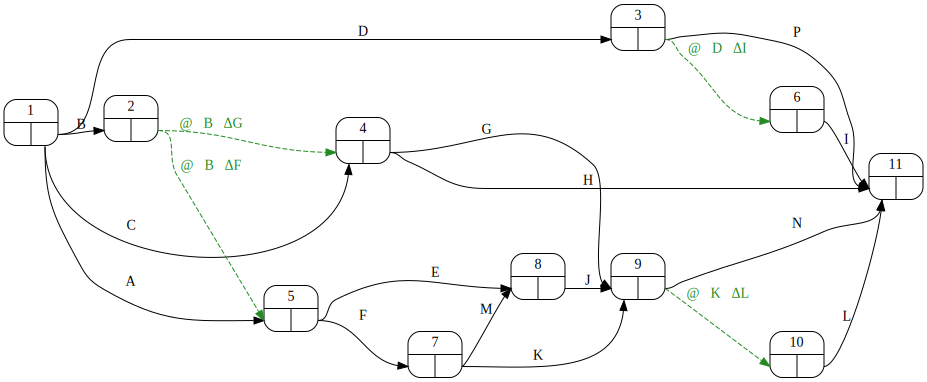

In [6]:
proyecto.pert()

Tabla de prelaciones distantes

In [7]:
pd.Series({key: ' '.join(sorted(value)) for key,value in proyecto.distant_predecessor().items()})

,0
A,
B,
C,
D,
E,A B
F,A B
G,B C
H,B C
I,D
J,A B E F M


##### Matriz de Zaderenko

In [8]:
proyecto.zaderenko(durations=datos_proyecto['duracion'])

,1,2,3,4,5,6,7,8,9,10,11,early
1,,6.0,3.0,1.0,3.0,,,,,,,0.0
2,,,,0.0,0.0,,,,,,,6.0
3,,,,,,0.0,,,,,3.0,3.0
4,,,,,,,,,2.0,,15.0,6.0
5,,,,,,,4.0,6.0,,,,6.0
6,,,,,,,,,,,18.0,3.0
7,,,,,,,,3.0,7.0,,,10.0
8,,,,,,,,,4.0,,,13.0
9,,,,,,,,,,0.0,1.0,17.0
10,,,,,,,,,,,1.0,17.0


In [9]:
resultados_pert = proyecto.calculate_pert(durations=datos_proyecto['duracion'])
resultados_pert['nodes']

,early,late
1,0,0
2,6,6
3,3,3
4,6,6
5,6,9
6,3,3
7,10,13
8,13,16
9,17,20
10,17,20


##### Holguras

In [10]:
resultados_pert['activities']

,H_total
@∇B⤑ΔF,3
@∇B⤑ΔG,0
@∇D⤑ΔI,0
@∇K⤑ΔL,3
A,6
B,0
C,5
D,0
E,4
F,3


###### Camino crítico

In [11]:
camino_critico = proyecto.critical_path(durations=datos_proyecto['duracion'])
camino_critico

{'Route_3': ['B', '@∇B⤑ΔG', 'H'], 'Route_11': ['D', '@∇D⤑ΔI', 'I']}

##### Grafo PERT con indicación de tiempos

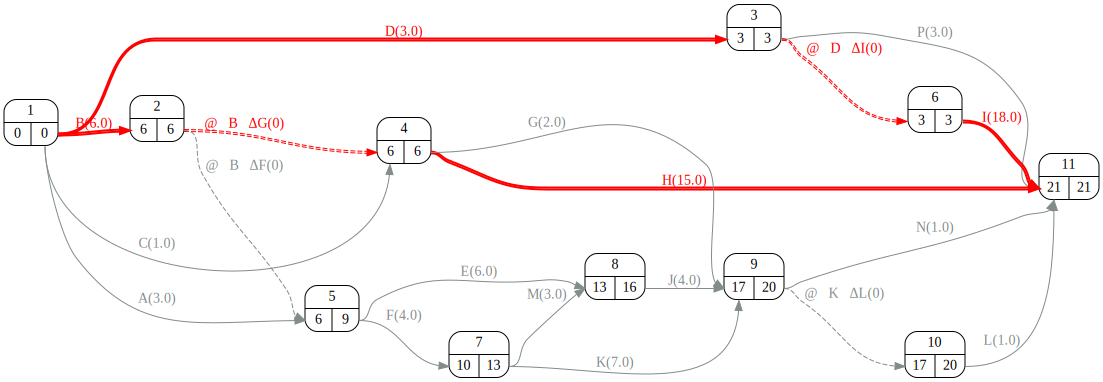

In [12]:
proyecto.pert(durations=datos_proyecto['duracion'])

### Apartado 2.

> Reduzca la duración del proyecto dos unidades de tiempo con el menor incremento de coste posible.


Se aborda la solución de este apartado mediante la técnica de reducción de la duración del proyecto con mínimo coste.

In [13]:
ackoff, best_option, durations, periods_available = proyecto.ackoff(durations=datos_proyecto['duracion'],
                         min_durations=datos_proyecto['duracion_tope'],
                         costs=datos_proyecto['cur']
                        )
ackoff

D shape (15,)
Path matrix shape (20, 15)


Step: 0,	 Best option: ['B', 'I'], 	 Cost: 7.0, 	 Critical paths: ['Route_3', 'Route_11']
Step: 1,	 Best option: ['D', 'B'], 	 Cost: 11.0, 	 Critical paths: ['Route_3', 'Route_11']
No more paths to reduce.







,A,B,C,D,E,F,G,H,I,J,K,L,M,N,P,0,1,2
Route_1,,4.0,,,,,100.0,,,,,,,,,9.0,8.0,7.0
Route_2,,4.0,,,,,100.0,,,,,,,,,9.0,8.0,7.0
Route_3,,4.0,,,,,,10.0,,,,,,,,21.0,20.0,19.0
Route_4,,4.0,,,150.0,,,,,0.0,,,,,,17.0,16.0,15.0
Route_5,,4.0,,,150.0,,,,,0.0,,,,,,17.0,16.0,15.0
Route_6,,4.0,,,,66.7,,,,,0.0,,,,,18.0,17.0,16.0
Route_7,,4.0,,,,66.7,,,,,0.0,,,,,18.0,17.0,16.0
Route_8,,4.0,,,,66.7,,,,0.0,,,0.0,,,18.0,17.0,16.0
Route_9,,4.0,,,,66.7,,,,0.0,,,0.0,,,18.0,17.0,16.0
Route_10,,,,7.0,,,,,,,,,,,75.0,6.0,6.0,5.0


La suma del sobrecoste de la primera y segunda iteración es de 18.

#### Proyecto con la duración reducida

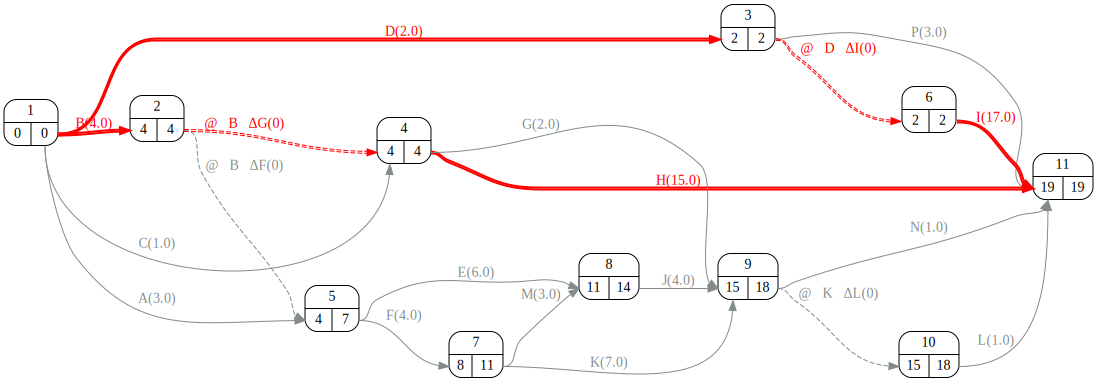

In [14]:
proyecto.pert(durations=durations)